In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
from pearce.emulator import OriginalRecipe, ExtraCrispy
from pearce.emulator import parameter, DEFAULT_PARAMS as PARAMS

In [37]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from itertools import cycle
colors = cycle(sns.color_palette())

In [38]:
training_dir = '/u/ki/swmclau2/des/PearceLHC_wp_rp'
fiducial_params = {'logM0': 12.20, 'logM1': 13.7, 'alpha': 1.02,
                      'logMmin': 12.1, 'f_c': 0.19, 'sigma_logM': 0.46}
rbins = np.array([  0.06309573,   0.12437607,   0.24517359,   0.34422476, 0.48329302, 0.67854546,\
           0.9526807 , 1.33756775,1.8779508 ,   2.6366509 ,   3.70186906,   5.19743987, 7.29722764, \
           10.24533859,  14.38449888,  20.1958975 , 28.35512583,  39.81071706] )
rpoints = (rbins[1:]+rbins[:-1])/2

In [39]:
y_param = 'logMmin'
emulation_point = [('f_c', 0.233), ('logM0', 12.0), ('sigma_logM', 0.533), 
                   ('alpha', 1.083),('logM1', 13.5), ('logMmin', 12.233)]
em_params = dict(emulation_point)
del em_params[y_param]

In [40]:
y_param_idx = -1
for idx, p in enumerate(PARAMS):
    if p.name==y_param:
        y_param_idx = idx
        break
        
y_vals = np.linspace(PARAMS[y_param_idx].low, PARAMS[y_param_idx].high, 4)
em_params[y_param] = y_vals

In [41]:
print em_params[y_param]

[ 11.7         11.96666667  12.23333333  12.5       ]


In [42]:
print len(em_params)

6


In [43]:
or_params = PARAMS[:]
or_params.append(parameter('r', 0, 1)) #95% sure bounds aren't used for r
emu1 = OriginalRecipe(training_dir,or_params)

In [44]:
emu1.get_training_data('/u/ki/swmclau2/des/PearceLHC_wp_rp', None, {})

In [45]:
emu1.x.shape

(8500, 7)

In [46]:
def f(x1,x2):
    return emu1.gp.kernel.value(np.array([x1]),np.array([x2]))

In [47]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
#regressor = RandomForestRegressor(n_estimators=int(1e3)) # use defaults for now
#regressor = GradientBoostingRegressor(n_estimators=int(1e3), max_depth=5)
regressor = SVR(C = 1,kernel = emu1.gp.kernel.value)
#regressor = KernelRidge(kernel = f)
#regressor = DecisionTreeRegressor()
#regressor = MLPRegressor((10,20), learning_rate_init=0.01)

In [48]:
emu1.x[0,:]

array([ 12.311     ,   0.571     ,  11.617     ,  13.934     ,
         1.236     ,   0.381     ,  -1.02809405])

In [49]:
emu1.y[0]

2.3084447270846553

In [50]:
emu1.x.shape

(8500, 7)

In [51]:
regressor.fit(emu1.x, emu1.y)

SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel=<bound method Product.value of ConstantKernel(1.18212664544, ndim=7) * ExpSquaredKernel(1.7348042925, 5.36288382789, 15.8416094906, 1.66509412286, 3.63498762588, 0.327508062386, 0.306139450843, ndim=7)>,
  max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [52]:
rpoints = np.logspace(np.log10(rbins[0]), np.log10(rbins[-1]), 200)

In [53]:
print emu1.y[0]
print emu1.y_hat

2.30844472708
0


In [54]:
em_params['r'] = np.log10(rpoints)
t_list = [em_params[p.name] for p in or_params if p.name in em_params]
t_grid = np.meshgrid(*t_list)
t = np.stack(t_grid).T
        # TODO george can sort?
t = t.reshape((-1, 7))

em_point = emu1._sort_params(t)
del em_params['r']

In [55]:
log_xi_pred = regressor.predict(em_point)
log_xi_cov = np.zeros((log_xi_pred.shape[0], log_xi_pred.shape[0]))

In [56]:
log_xi_err = np.sqrt(np.diag(log_xi_cov))
log_xi_pred = log_xi_pred.reshape((-1, len(rpoints)))
log_xi_err = log_xi_err.reshape((-1, len(rpoints)))

In [57]:
truth_dir = '/u/ki/swmclau2/des/PearceFHC_wp_rp/'
plot_r, plot_xi, plot_xi_err = emu1.get_plot_data(em_params,truth_dir, independent_variable=None)

In [58]:
plot_xi.shape, plot_r.shape, plot_xi_err.shape

((4, 17), (4, 17), (4, 17))

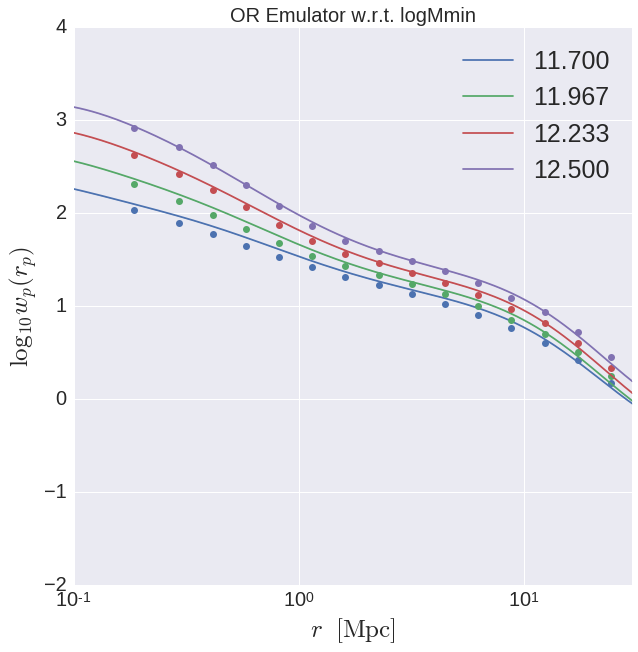

In [59]:
fig = plt.figure(figsize = (10, 10))
for label, lxp, lxe,pr, px, err,c in zip(y_vals, log_xi_pred, log_xi_err ,plot_r, plot_xi,plot_xi_err,colors):

    plt.plot(rpoints, lxp,label = '%.3f'%label, color = c )

    plt.fill_between(rpoints,lxp+lxe,
                     lxp-lxe, color = c, alpha = 0.3)

    plt.errorbar(10**pr, px,err, color =c,fmt = 'o')

plt.xlim(xmin = 0.1, xmax = 30)    
plt.ylim(ymin = -2, ymax = 4)
plt.title("OR Emulator w.r.t. %s"%y_param, fontsize =20)
#plt.loglog()
plt.xscale('log')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$r $  $\rm{[Mpc]}$', fontsize=25)
plt.ylabel(r'$\log_{10}{w_p(r_p) }$', fontsize=25)
plt.legend(loc='best', fontsize=25)

In [60]:
from glob import glob
from os import path
truth_dir = '/u/ki/swmclau2/des/PearceFHC_wp_rp'
N=None
statistic = 'rel'
cov_files = glob(path.join(truth_dir, 'cov*.npy'))
obs_files = glob(path.join(truth_dir, 'obs*.npy'))

In [61]:
from pearce.emulator import GLOBAL_FILENAME, global_file_reader, obs_file_reader
from time import time

In [62]:
np.random.seed(int(time()))

if N is None:
    idxs = np.arange(len(obs_files))
else:
    idxs = np.random.choice(len(obs_files), N, replace=False)

values = []
bins, _, _, _ = global_file_reader(path.join(truth_dir, GLOBAL_FILENAME))
bin_centers = (bins[1:] + bins[:-1]) / 2
for idx in idxs:
    params, true_obs, _ = obs_file_reader(obs_files[idx], cov_files[idx])
    #pred_log_obs, _ = self.emulate_wrt_r(params, bin_centers)
    params['r'] = np.log10(bin_centers)
    t_list = [params[p.name] for p in or_params if p.name in params]
    t_grid = np.meshgrid(*t_list)
    t = np.stack(t_grid).T
    # TODO george can sort?
    t = t.reshape((-1, 7))

    em_point = emu1._sort_params(t)
    del params['r']
    
    pred_log_obs = regressor.predict(em_point)

    if statistic == 'rmsfd':
        values.append(np.sqrt(np.mean(((pred_log_obs - np.log10(true_obs)) ** 2) / (np.log10(true_obs) ** 2))))
    elif statistic == 'r2':  # r2
        SSR = np.sum((pred_log_obs - np.log10(true_obs)) ** 2)
        SST = np.sum((np.log10(true_obs) - np.log10(true_obs).mean()) ** 2)

        values.append(1 - SSR / SST)

    elif statistic == 'abs':
        values.append((pred_log_obs - np.log10(true_obs)) )
        #values.append((10**pred_log_obs - true_obs) )
    else: #'rel'
        values.append(((pred_log_obs - np.log10(true_obs)) )/np.log10(true_obs) )
        #values.append((10**pred_log_obs - true_obs )/true_obs )
values = np.array(values)

In [63]:
np.savetxt('svr_fhc.npy',values)

In [64]:
gbt_err = np.abs(values).mean(axis=0)*100

In [65]:
print gbt_err

[   3.21251073    3.1024153     3.05920444    3.09134413    3.22519959
    3.33045103    3.28061513    3.17086453    2.93560402    3.36712271
    4.84067679    6.93957559    8.82737469    7.0109115     6.57028145
   18.27534284  389.55373394]


In [66]:
#FHC wp
gp_err = np.array([3.50471281,2.57032543,3.87352454,2.46725702,2.74530995,
    2.92839825,2.87002776,2.65217555,3.02727471, 3.56926359,
    3.55512203, 4.12491033, 5.32400928, 7.57056716, 11.71321403,
   54.55453398,721.94475929])

In [67]:
gbt_err = gbt_err/100
gp_err = gp_err/100

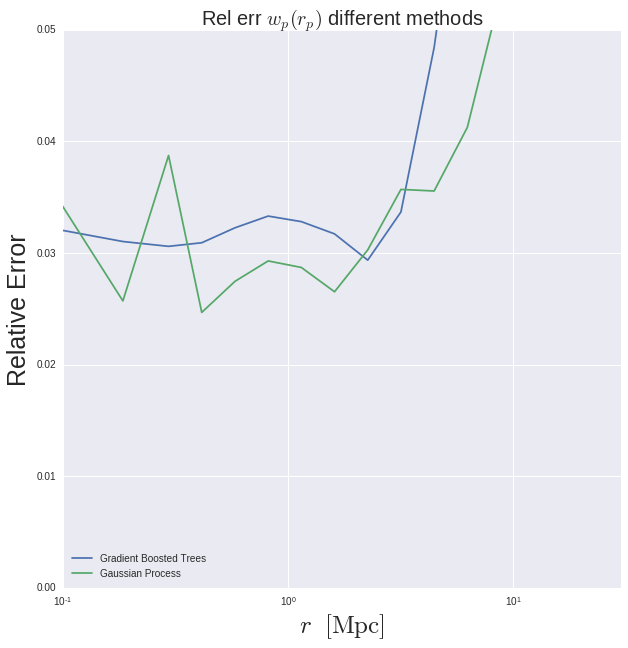

In [68]:
fig = plt.figure(figsize = (10, 10))
plt.plot(bin_centers, gbt_err, label='Gradient Boosted Trees')
plt.plot(bin_centers, gp_err, label = 'Gaussian Process')

plt.xlim(xmin = 0.1, xmax = 30)
plt.ylim(ymin = 0, ymax = 0.05)
plt.title(r"Rel err $w_p(r_p)$ different methods", fontsize =20)
#plt.loglog()
plt.xscale('log')
plt.xlabel(r'$r $  $\rm{[Mpc]}$', fontsize=25)
plt.ylabel(r'Relative Error', fontsize = 25)
plt.legend(loc='best')